# Проект: AB-тест для дейтингового приложения
    
В приложении есть базовые функции, премиум-подписка с доступом к дополнительным возможностям.
Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран  изменена стоимость премиум-подписки* при покупке через две новые платежные системы. 
<br>При этом стоимость пробного периода оставалась прежней.
<br>*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

<br><b> Цели: </b>
проверить успешность эксперимента в целом.

<br><b> Задачи: </b>
- провести анализ данных
- посчитать метрики
- оценить эксперимент

#### Ход работ:
- провести исследование данных (описательные: набор полей, тип данных, размер таблиц; качественные: проверка на пустые значения и дубликаты)
- сверить выполнение требований к эксперименту на датасетах
- подобрать метрики
- проверить корреляцию между типами оплат
- проанализировать распредление, оценить выбросы
- A/B-тест, оценка результатов, выводы, рекомендации

#### Данные
Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). 
<br>Для каждой из них:

<br><b><i>users_*.csv</i></b> – информация о пользователях:
<br><i>uid</i> – идентификатор пользователя
<br><i>age</i> – возраст
<br><i>attraction_coeff</i> – коэффициент привлекательности (от 0 до 1000, \${лайки}/{просмотры} * 1000$)
<br><i>coins</i> – число монеток (внутренняя валюта)
<br><i>country</i> – страна
<br><i>visit_days</i> – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
<br><i>gender</i> – пол
<br><i>age_filter_start</i>  – фильтр поиска, мин. значение 
<br><i>age_filter_end</i>  – фильтр поиска, макс. значение 
<br><i>views_count</i> – число полученных оценок 
<br><i>was_premium</i> – был ли когда-либо премиум (либо пробный период премиум-статуса, 
                                         либо купленный за деньги)
<br><i>is_premium</i> –  является ли премиум
<br><i>total_revenue</i> – нормированная выручка 

<br><b><i>transactions_*.csv</i></b> – информация о платежах пользователей:
<br><i>uid</i> – идентификатор пользователя
<br><i>country</i> – страна
<br><i>joined_at</i> – дата и время регистрации
<br><i>paid_at</i> – дата и время покупки
<br><i>revenue</i> – нормированная выручка
<br><i>payment_id</i> – идентификатор платежа
<br><i>from_page</i> – откуда пользователь перешел на страницу оплаты
<br><i>product_type</i> – тип продукта (trial_premium – пробная премиум-подписка, 
                             premium_no_trial – премиум-подписка без пробной, 
                             coins – подписка за внутреннюю валюту, 
                             other_type – другое) 

#### Файлы:
<br><i>users_test</i> – информация о пользователях в тестовой группе. 
<br><i>users_control_1</i> – информация о пользователях в первой контрольной группе. 
<br><i>users_control_2</i> – информация о пользователях во второй контрольной группе . 
<br><i>transactions_test</i> – информация о платежах пользователей в тестовой группе. 
<br><i>transactions_control_1</i> – информация о платежах пользователей в первой контрольной группе. 
<br><i>transactions_control_2</i> – информация о платежах пользователей во второй контрольной группе 

## Работа с исходными данными

In [163]:
# блок импорта библиотек
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
# import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

In [164]:
# скрываем предупреждения
import warnings
warnings.filterwarnings("ignore")

In [165]:
# Загрузка источников
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key1 = 'https://disk.yandex.ru/d/4XXIME4osGrMRA'  # ссылка на яндекс диск
public_key2 = 'https://disk.yandex.ru/d/yJFydMNNGkEKfg'
public_key3 = 'https://disk.yandex.ru/d/br6KkQupzzTGoQ'
public_key4 = 'https://disk.yandex.ru/d/gvCWpZ55ODzs2g'
public_key5 = 'https://disk.yandex.ru/d/VY5W0keMX5TZBQ'
public_key6 = 'https://disk.yandex.ru/d/th5GL0mGOc-qzg'

def source(link_yd, fl=True):
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=link_yd))
    response = requests.get(final_url)
    download_url = response.json()['href']
    if fl:
        return pd.read_csv(download_url, sep=';')  # условие для чтения источника по пользователям
    else:
        return pd.read_csv(download_url, sep=';', parse_dates = ['joined_at', 'paid_at'])  # условие для чтения источника по транзакциям

user_test = source(public_key1)
user_control1 = source(public_key2)
user_control2 = source(public_key3)
transactions_test = source(public_key4, False)
transactions_control1 = source(public_key5, False)
transactions_control2 = source(public_key6, False)

In [166]:
# размер датасетов
print(f'size')
print(f'user_test  {user_test.shape}')
print(f'user_control1  {user_control1.shape}')
print(f'user_control2  {user_control2.shape}')
print(f'transactions_test  {transactions_test.shape}')
print(f'transactions_control1  {transactions_control1.shape}')
print(f'transactions_control2  {transactions_control2.shape}')

size
user_test  (4308, 13)
user_control1  (4340, 13)
user_control2  (4264, 13)
transactions_test  (273, 8)
transactions_control1  (1007, 8)
transactions_control2  (328, 8)


In [167]:
# структура дата сета по пользователям
user_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [168]:
# тип данных в дата сете по пользователям
user_test.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

Пустые значения в дата сете по пользователям в колонках coins, visit_days, was_premium, is_premium допустимы.

In [169]:
# проверка на пустые значения дата сета по пользователям
user_test.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [170]:
user_control1.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4280
country                0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3904
is_premium          4148
total_revenue          0
dtype: int64

In [171]:
user_control2.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4203
country                0
visit_days          1364
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3853
is_premium          4073
total_revenue          0
dtype: int64

In [172]:
# проверка на дубликаты, в таблицах по пользователям дубликатов нет
user_test.loc[user_test.duplicated()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue


In [173]:
user_control1.loc[user_control1.duplicated()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue


In [174]:
user_control2.loc[user_control2.duplicated()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue


In [175]:
# структура дата сета по транзакциям
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [176]:
transactions_test.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

In [177]:
# проверка на пустые значения дата сета по транзакциям
transactions_test.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

В датасете transactions_control1 найдены пустые значения, это пустые строки, убираем такие строки

In [178]:
transactions_control1.isna().sum()

uid             630
country         630
joined_at       630
paid_at         630
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [179]:
transactions_control1.tail()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
1002,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1006,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [180]:
transactions_control1 = transactions_control1.dropna()
transactions_control1.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [181]:
transactions_control2.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

В таблицах по транзакциям выявлены дубликаты по product_type other и coins. Так как совпадение до секунд, допускаем, что это реальные дубликаты, возможно из-за особенностей системы сбора данных. Дубликаты убираем, чтобы исключить смещение в доходах от покупателя (revenue).

In [182]:
# проверка на дубликаты
transactions_test.loc[transactions_test.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
55,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
96,892050108,Israel,2017-10-22 03:02:00,2017-10-23 02:53:00,1261,19,empty_likes,coins
127,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
158,891508155,Latvia,2017-02-11 09:46:00,2017-03-11 22:06:00,936,19,empty_likes,coins
188,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins
205,892202526,United States of America,2017-10-18 20:34:00,2017-10-20 19:54:00,897,19,menu,coins
243,892339626,United States of America,2017-10-15 23:21:00,2017-10-20 18:14:00,754,19,empty_likes,coins


In [183]:
transactions_control1.loc[transactions_control1.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
47,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
88,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
93,891367521.0,Italy,2017-05-11 02:37:00,2017-10-11 01:52:00,1469.0,19.0,sympathy,other_type
169,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
176,892207959.0,France,2017-10-18 18:30:00,2017-10-22 04:49:00,1261.0,19.0,empty_likes,coins
198,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
206,891739737.0,United States of America,2017-10-28 18:50:00,2017-11-13 05:34:00,1261.0,19.0,empty_likes,coins
216,891452706.0,Italy,2017-03-11 14:48:00,2017-11-11 17:21:00,6305.0,19.0,gifts,coins
223,891721851.0,United States of America,2017-10-29 02:50:00,2017-11-14 04:08:00,897.0,19.0,empty_likes,coins
233,891365490.0,United States of America,2017-05-11 03:55:00,2017-06-11 00:28:00,1261.0,19.0,empty_likes,coins


In [184]:
transactions_control2.loc[transactions_control2.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
86,891862596,Italy,2017-10-26 01:40:00,2017-10-30 09:01:00,1261,19,empty_likes,coins
235,892064328,United States of America,2017-10-21 20:54:00,2017-10-22 01:30:00,6305,19,empty_likes,coins
241,892009254,Italy,2017-10-22 22:57:00,2017-10-23 00:06:00,2353,67,empty_likes,other_type
288,892062660,United States of America,2017-10-21 21:28:00,2017-10-31 00:53:00,1261,19,empty_likes,coins
321,892045743,Israel,2017-10-22 07:04:00,2017-10-23 20:17:00,1261,19,empty_likes,coins


In [185]:
transactions_test = transactions_test.drop_duplicates()
transactions_control1 = transactions_control1.drop_duplicates()
transactions_control2 = transactions_control2.drop_duplicates()

## Check up требований к исследованию

<b>Условия эксперимента:</b>
<br>1)Исследование для новых пользователей
<br>2)Ограниченный список стран
<br>3)Изменяемая feature - стоимость премиум-подписки
<br>4)2 новые системы оплаты

<b>1)Исследование для новых пользователей</b>
<br><b>1.1)</b> Новых пользователей можно определить по времени с момента регистрации, например разница между joined_at и paid_at не больше N дней.
<br> Проверим дельту между датой регистрации и датой оплаты.
<br><b>1.2)</b> Другой способ считать новым пользователем любого, кто не пробовал премиум-подписку ранее. 
<br>Есть отметка was_premium, без привязки к периоду. 
<br>Проверим отметку was_premium для пользователей, у которых во время эксперимента не было премиум подписки. Если найдём таких пользователей, они не подходят под критерий "новый", у них уже была подписка.
<br>Все остальные подписки премиум считаем в рамках эксперимента и выбранного периода 2017 год.

In [186]:
# период регистрации пользователей попадает с января17 по октябрь17
transactions_test.joined_at.describe()

count                     266
unique                    146
top       2017-10-18 01:09:00
freq                       11
first     2017-01-11 03:07:00
last      2017-10-31 23:40:00
Name: joined_at, dtype: object

In [187]:
transactions_control1.joined_at.describe()

count                     356
unique                    193
top       2017-10-16 01:38:00
freq                       19
first     2015-01-19 11:49:00
last      2017-10-31 22:17:00
Name: joined_at, dtype: object

In [188]:
transactions_control2.joined_at.describe()

count                     323
unique                    187
top       2017-10-30 15:22:00
freq                       11
first     2017-01-11 08:36:00
last      2017-10-31 17:43:00
Name: joined_at, dtype: object

<br><b>1.1)</b> Проверяем дельту между датой регистрации и датой оплаты.

In [189]:
# заводим поле с разницей дат
transactions_test = transactions_test.assign(date_dif = transactions_test.paid_at - transactions_test.joined_at)
transactions_test.date_dif.unique()

array([ 16077840000000000,    695040000000000,    428760000000000,
          854940000000000,    698400000000000,    131160000000000,
        23608680000000000,  18496800000000000,      6720000000000,
             420000000000,    146340000000000,  -1238100000000000,
         2743140000000000,    613260000000000,    263160000000000,
         2463600000000000,    191700000000000,    421140000000000,
        18324000000000000,     83400000000000, -19864740000000000,
        13220940000000000,     22620000000000,    221700000000000,
       -19864800000000000,  -6211140000000000,   5246280000000000,
           94680000000000,     75780000000000,   4547700000000000,
            9180000000000,       720000000000,    612000000000000,
        10887540000000000,   1153800000000000,    698820000000000,
        -4314720000000000, -16800540000000000,  -6126900000000000,
          519600000000000,    802560000000000,   2683560000000000,
        23608860000000000,   5265180000000000,    267720000000

In [190]:
transactions_test.head(20)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,date_dif
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium,186 days 02:04:00
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium,8 days 01:04:00
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type,4 days 23:06:00
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type,9 days 21:29:00
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium,8 days 02:00:00
5,892426491,United States of America,2017-10-14 10:13:00,2017-10-15 22:39:00,12597,147,autoreply_message,premium_no_trial,1 days 12:26:00
6,891558921,United States of America,2017-01-11 03:07:00,2017-10-11 09:05:00,9100,147,left_sidebar_menu,premium_no_trial,273 days 05:58:00
7,891322086,United States of America,2017-05-11 19:20:00,2017-12-11 21:20:00,9919,147,trial_vip_popup,trial_premium,214 days 02:00:00
8,891999783,United States of America,2017-10-23 04:21:00,2017-10-23 06:13:00,1261,19,autorefill,coins,0 days 01:52:00
9,892202526,United States of America,2017-10-18 20:34:00,2017-10-18 20:41:00,897,146,ad_to_photo,coins,0 days 00:07:00


In [191]:
# смотрим разброс мин и макс значения
transactions_test.date_dif.describe()

count                            266
mean       0 days 03:25:04.060150375
std      105 days 02:24:49.510038614
min              -288 days +02:12:00
25%                  0 days 00:12:00
50%                  2 days 02:17:30
75%                 12 days 15:23:45
max                302 days 00:42:00
Name: date_dif, dtype: object

Обнаружены отрицательные значения по разнице дат, т.е. есть строки, где дата покупки раньше даты регистрации.
<br>Нужно исключить таких пользователей. 
<br>В дальнейшем выяснить причину/найти объяснение случаев, где дата оплаты раньше даты регистрации - сбой, нормальная особенность порядка событий (регистрация необязательна, пользователь это просто посетитель), затерта/потеряна часть логов.

In [192]:
# делаем список uid для исключения пользователей
uid_list = list(transactions_test.query('date_dif < "0 days"').uid.unique())

# исключаем строки из transactions_test
transactions_test = transactions_test.query('uid not in @uid_list')

# исключаем пользователей из user_test
user_test = user_test.query('uid not in @uid_list')

In [193]:
# прорабатываем такй же кейс с датой оплаты раньше даты регистрации для датасета control1

# заводим поле с разницей дат
transactions_control1 = transactions_control1.assign(date_dif = transactions_control1.paid_at - transactions_control1.joined_at)

# смотрим разброс мин и макс значения
transactions_control1.date_dif.describe()

count                            356
mean      13 days 02:03:34.382022472
std      116 days 00:16:14.200656952
min              -289 days +18:23:00
25%                  0 days 00:21:45
50%                  2 days 21:10:30
75%                 30 days 11:09:30
max                695 days 05:46:00
Name: date_dif, dtype: object

In [194]:
# делаем список uid для исключения пользователей
uid_list = list(transactions_control1.query('date_dif < "0 days"').uid.unique())

# исключаем строки из transactions_control1
transactions_control1 = transactions_control1.query('uid not in @uid_list')

# исключаем пользователей из user_control1
user_control1 = user_control1.query('uid not in @uid_list')

In [195]:
# прорабатываем такой же кейс с датой оплаты раньше даты регистрации для датасета control2

# заводим поле с разницей дат
transactions_control2 = transactions_control2.assign(date_dif = transactions_control2.paid_at - transactions_control2.joined_at)

# смотрим разброс мин и макс значения
transactions_control2.date_dif.describe()

count                             323
mean     -15 days +02:03:21.547987616
std        96 days 19:28:42.838963630
min               -293 days +21:12:00
25%                   0 days 00:10:30
50%                   1 days 09:51:00
75%                   7 days 02:19:30
max                 214 days 02:04:00
Name: date_dif, dtype: object

In [196]:
# делаем список uid для исключения пользователей
uid_list = list(transactions_control2.query('date_dif < "0 days"').uid.unique())

# исключаем строки из transactions_control1
transactions_control2 = transactions_control2.query('uid not in @uid_list')

# исключаем пользователей из user_control1
user_control2 = user_control2.query('uid not in @uid_list')

<br><b>1.2)</b> Проверяем отметку was_premium для пользователей, у которых во время эксперимента не было премиум подписки.

In [197]:
# для test
# готовим список пользователей хотя бы с одной покупкой премиум подписки
premium_id = list(transactions_test
                  .query('product_type in ["trial_premium", "premium_no_trial"]')
                  .uid
                  .unique())

# отбираем строки без премиум подписок, добавляем поля из таблицы user_test, фильтруем по was_premium = 1, преобразовываем в список uid
was_premium_uid = list(transactions_test
    .query('uid not in @premium_id')
    .merge(user_test, on='uid')
    .query('was_premium == 1')
    .uid
    .unique())


# исключаем новый список uid из датасетов - пользователей с подпиской премиум в прошлых периодах не считаем новыми
user_test = user_test.query('uid not in @was_premium_uid')
transactions_test = transactions_test.query('uid not in @was_premium_uid')

In [198]:
# для control1
# готовим список пользователей хотя бы с одной покупкой премиум подписки
premium_id = list(transactions_control1
                  .query('product_type in ["trial_premium", "premium_no_trial"]')
                  .uid
                  .unique())

# отбираем строки без премиум подписок, добавляем поля из таблицы user_test, фильтруем по was_premium = 1, преобразовываем в список uid
was_premium_uid = list(transactions_control1
    .query('uid not in @premium_id')
    .merge(user_control1, on='uid')
    .query('was_premium == 1')
    .uid
    .unique())


# исключаем новый список uid из датасетов - пользователей с подпиской премиум в прошлых периодах не считаем новыми
user_control1 = user_control1.query('uid not in @was_premium_uid')
transactions_control1 = transactions_control1.query('uid not in @was_premium_uid')

In [199]:
# для control1
# готовим список пользователей хотя бы с одной покупкой премиум подписки
premium_id = list(transactions_control2
                  .query('product_type in ["trial_premium", "premium_no_trial"]')
                  .uid
                  .unique())

# отбираем строки без премиум подписок, добавляем поля из таблицы user_test, фильтруем по was_premium = 1, преобразовываем в список uid
was_premium_uid = list(transactions_control2
    .query('uid not in @premium_id')
    .merge(user_control2, on='uid')
    .query('was_premium == 1')
    .uid
    .unique())


# исключаем новый список uid из датасетов - пользователей с подпиской премиум в прошлых периодах не считаем новыми
user_control2 = user_control2.query('uid not in @was_premium_uid')
transactions_control2 = transactions_control2.query('uid not in @was_premium_uid')

<b>2)Ограниченный список стран</b>
<br>Для всех датасетов отбираем строки только со странами, которые есть в transactions_test. Можно предположить, что по каким-то странам не удалось собрать наблюдения в тестовой выборке, но достоверного подтверждения нет.

In [200]:
# создаём список стран
country_list = list(transactions_test.country.unique())
country_list

['Italy',
 'United States of America',
 'Spain',
 'United Arab Emirates',
 'Latvia',
 'Argentina',
 'United Kingdom (Great Britain)',
 'Israel',
 'Switzerland',
 'Germany',
 'France',
 'Chile',
 'Canada',
 'Mexico',
 'Turkey',
 'Belgium']

In [201]:
user_test = user_test.query('country in @country_list')
user_control1 = user_control1.query('country in @country_list')
user_control2 = user_control2.query('country in @country_list')
transactions_control1 = transactions_control1.query('country in @country_list')
transactions_control2 = transactions_control2.query('country in @country_list')

<b>3)Изменяемая feature - стоимость премиум-подписки</b>
<br>Для метрик, расчитываемых по премиум-подписке, используем product_type = premium_no_trial и trial_premium.
<br>Применение фильтра определим в блоке корреляционного анализа и дальнейших шагах.

In [202]:
transactions_control1.product_type.unique()

array(['trial_premium', 'coins', 'other_type', 'premium_no_trial'],
      dtype=object)

<b>4)2 новые системы оплаты</b>
<br>Отметок о совершении покупки новой системой оплаты в датасетах нет. Косвенно (по суммам дохода и payment_id) закономерностей в оплатах не выявлено. Принимаем факт, что у пользователя был выбор систем оплат.

In [203]:
# уникальные значения 'country', 'product_type', 'payment_id', 'revenue' в тестовом датасете транзакций
transactions_test[['country', 'product_type', 'payment_id', 'revenue']].drop_duplicates().sort_values(['country', 'product_type', 'payment_id']).head(50)

,country,product_type,payment_id,revenue
44,Argentina,coins,19,31525
95,Argentina,premium_no_trial,147,5330
121,Argentina,premium_no_trial,147,12597
267,Argentina,premium_no_trial,147,6292
18,Argentina,trial_premium,147,13767
211,Belgium,trial_premium,147,12831
83,Canada,premium_no_trial,147,4706
253,Canada,premium_no_trial,147,12597
103,Canada,trial_premium,147,9815
117,Canada,trial_premium,147,12766


In [204]:
# уникальные значения 'country', 'product_type', 'payment_id', 'revenue' в control1 датасете транзакций
transactions_control1[['country', 'product_type', 'payment_id', 'revenue']].drop_duplicates().sort_values(['country', 'product_type', 'payment_id']).head(50)

,country,product_type,payment_id,revenue
95,Argentina,coins,19.0,3926.0
142,Argentina,coins,19.0,6305.0
165,Argentina,coins,19.0,1261.0
252,Argentina,coins,146.0,741.0
36,Argentina,premium_no_trial,147.0,5278.0
105,Argentina,premium_no_trial,147.0,6292.0
69,Argentina,trial_premium,147.0,10023.0
110,Argentina,trial_premium,147.0,10517.0
267,Argentina,trial_premium,147.0,10556.0
326,Argentina,trial_premium,147.0,13884.0


## Метрики

В рамках эксперимента у пользователя произошло 2 изменения:
    <br>1)Дополнена механика оплаты - функциональное изменение
    <br>2)Изменена стоимость оплаты - экономика
<br>Мы оцениваем эти изменения совместно, но так как они оба касаются шага оплаты, можно выбрать общую денежную метрику.

В качестве основной метрики используем <i>ARPU</i>, т.к. этот показатель учитывает и изменения пользователей в покупателей и изменение доходов от покупателя.
<br>\${ARPU} = {Доходы} / {ВсегоПользователей}\$
<br>Средний чек мог бы также напрямую показывать изменения в доходах, но это изменение в любом случае будет, т.к. поменялась цена подписки, мы можем даже получить снижение среднего чека, но общий эффект не изменится.
<br>В качестве вспомогательных прокси-метрик возьмём CR из пользователя в покупателя и ARPPU. 
<br>\${CR} = {Покупатели} / {ВсегоПользователей}\$
<br>\${ARPPU} = {Доходы} / {Покупатели}\$
<br>Оценим их в динамике, чтобы посмотреть за счёт чего изменится ARPU - из-за конверсии или из-за суммы дохода.
<br>\${ARPU} = {Конверсия} * {ARPPU}\$
<br>Далее оценим корреляцию между доходами от типов продуктов и определимся в необходимости оценивать общий эфффект на ARPU или работать только с премиум-подпиской.

## Корреляционный анализ

Корреляционный анализ проведён для определения связи между доходами от разных типов продуктов, т.е. нет ли закономерности в расходах пользователей на продукты.
<br>Проверяем предположение, что выбор одного типа продукта не повлияет на выбор другого типа продукта.

<br><b>Механика:</b> корреляционный анализ проведён на нескольких срезах: детализация до дата_время + uid, детализация до дата + uid, детализация до месяц + uid, детализация до uid. 
<br>Распределения по типам продуктов подвергались нормализации через исключение выбросов и логарифмирование.

<br><b>Результат:</b> при различных срезах и нормализации на тестовом и контрольных датасетах высоких значений корреляции между coins, others и продуктами premium не обнаружено. Корреляции держались в значениях до 0.6, что не даёт основания говорить о сильной связи между типами продуктов.

<br><b>Вывод:</b> не можем подтвердить влияние выбора продуктов coins, others и продуктов premium друг на друга.
<br>Ниже итоги по срезу с нормализацией для тестового датасета. Остальные эксперименты не добавлены, чтобы не нагружать проект.

In [205]:
# готовим массив с колонками-типами продукта
#     .assign(paid_at = pd.to_datetime(transactions_test.paid_at).dt.date) \
#     .assign(paid_at = pd.to_datetime(transactions_test.paid_at).dt.month) \
#     .pivot_table('revenue', index='uid', columns='product_type', aggfunc='sum') \
#     .query('coins < 20000 and other_type < 20000 and premium_no_trial < 20000 and trial_premium < 20000')
prod_types_tab = transactions_test \
    .assign(paid_at = pd.to_datetime(transactions_test.paid_at).dt.date) \
    .pivot_table('revenue', index='uid', columns='product_type', aggfunc='sum')
prod_types_tab = prod_types_tab \
    .assign(coins = np.log(prod_types_tab.coins), other_type = np.log(prod_types_tab.other_type), premium_no_trial = np.log(prod_types_tab.premium_no_trial), trial_premium = np.log(prod_types_tab.trial_premium)) \
    .fillna(0) \
    .reset_index()[['coins', 'other_type', 'premium_no_trial', 'trial_premium']]
prod_types_tab = prod_types_tab \
    .assign(premium_all = prod_types_tab.premium_no_trial + prod_types_tab.trial_premium)[['coins', 'other_type', 'premium_no_trial', 'trial_premium', 'premium_all']]

prod_types_tab

product_type,coins,other_type,premium_no_trial,trial_premium,premium_all
0,0.000000,0.000000,9.116030,0.000000,9.116030
1,0.000000,0.000000,9.441214,0.000000,9.441214
2,0.000000,9.523398,0.000000,9.575261,9.575261
3,6.799056,0.000000,0.000000,0.000000,0.000000
4,9.442245,8.238273,11.639355,0.000000,11.639355
...,...,...,...,...,...
95,0.000000,0.000000,9.441214,0.000000,9.441214
96,0.000000,0.000000,0.000000,9.451481,9.451481
97,0.000000,0.000000,0.000000,9.114600,9.114600
98,8.621733,0.000000,8.192570,0.000000,8.192570


In [206]:
sns.set(
font_scale=2,
style="whitegrid",
rc={'figure.figsize':(5,5)}
        )

# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set(style="ticks", rc=custom_params)

(array([48.,  0.,  0.,  0.,  0.,  0.,  1., 34., 15.,  2.]),
 array([ 0.        ,  1.16393555,  2.32787109,  3.49180664,  4.65574218,
         5.81967773,  6.98361327,  8.14754882,  9.31148436, 10.47541991,
        11.63935545]),
 <a list of 10 Patch objects>)

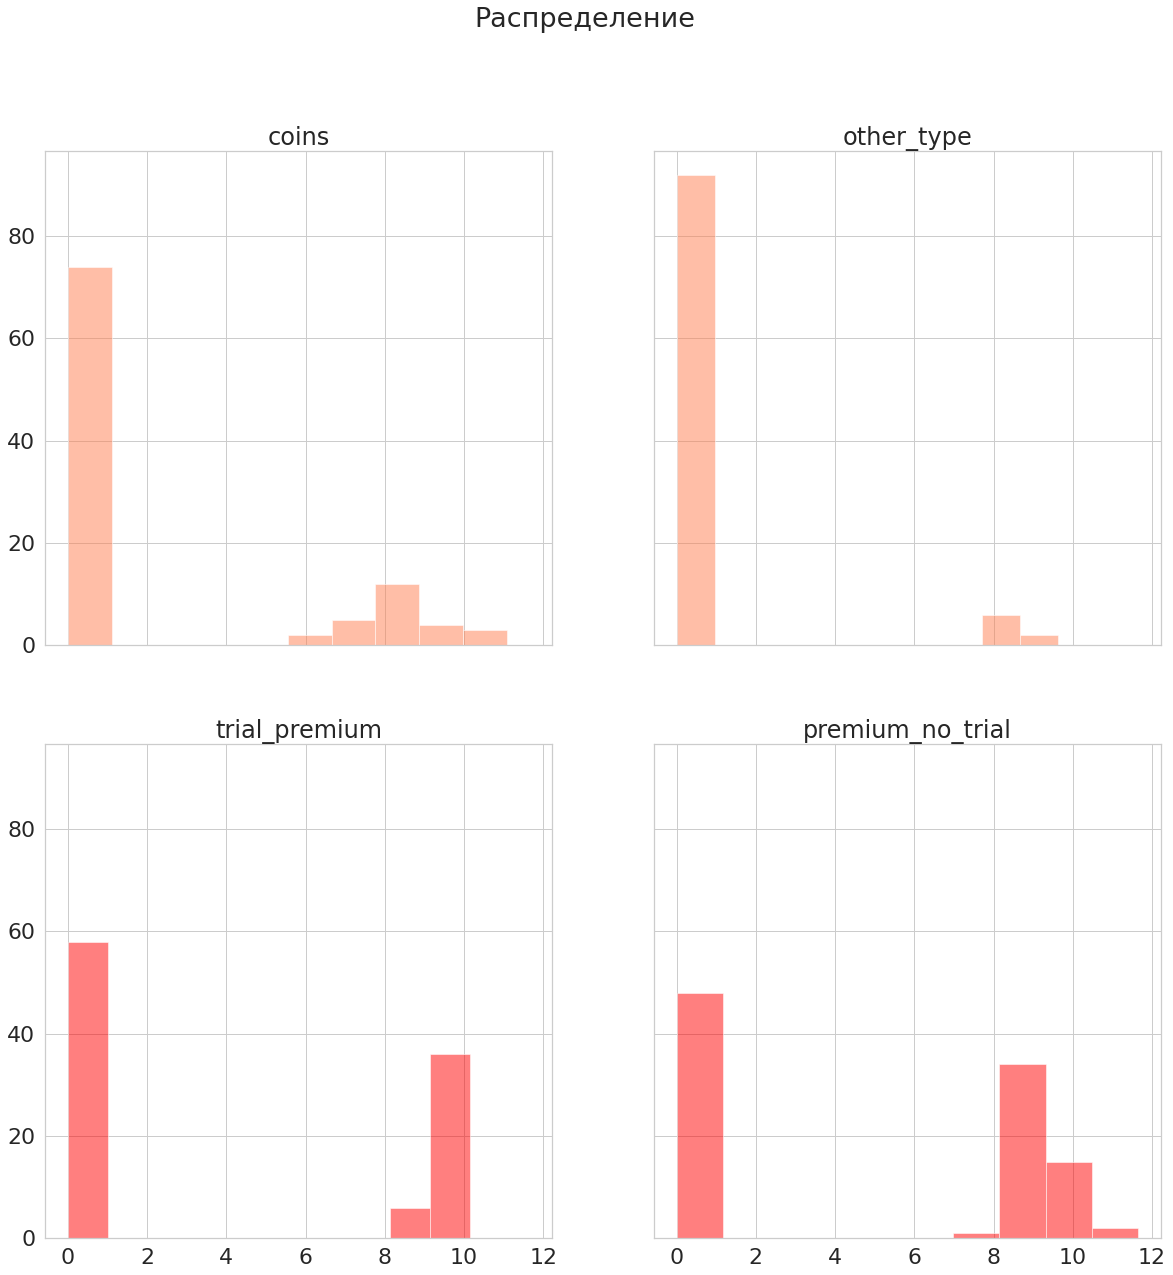

In [207]:
# Графики распределения

# import matplotlib.dates as mdates

#задаём значения для будущих осей
var1 = prod_types_tab.coins
var2 = prod_types_tab.other_type
var3 = prod_types_tab.trial_premium
var4 = prod_types_tab.premium_no_trial

#задаём сетку, совместное использование осей
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20), sharey=True, sharex=True)

#заголовок
fig.suptitle('Распределение', fontsize=27)

# подзаголовки графиков
axs[0, 0].set_title("coins")
axs[0, 1].set_title("other_type")
axs[1, 0].set_title("trial_premium")
axs[1, 1].set_title("premium_no_trial")


#добавляем данные на графики
axs[0, 0].hist(var1, alpha=0.5, color='coral')
axs[0, 1].hist(var2, alpha=0.5, color='coral')
axs[1, 0].hist(var3, alpha=0.5, color='red')
axs[1, 1].hist(var4, alpha=0.5, color='red')

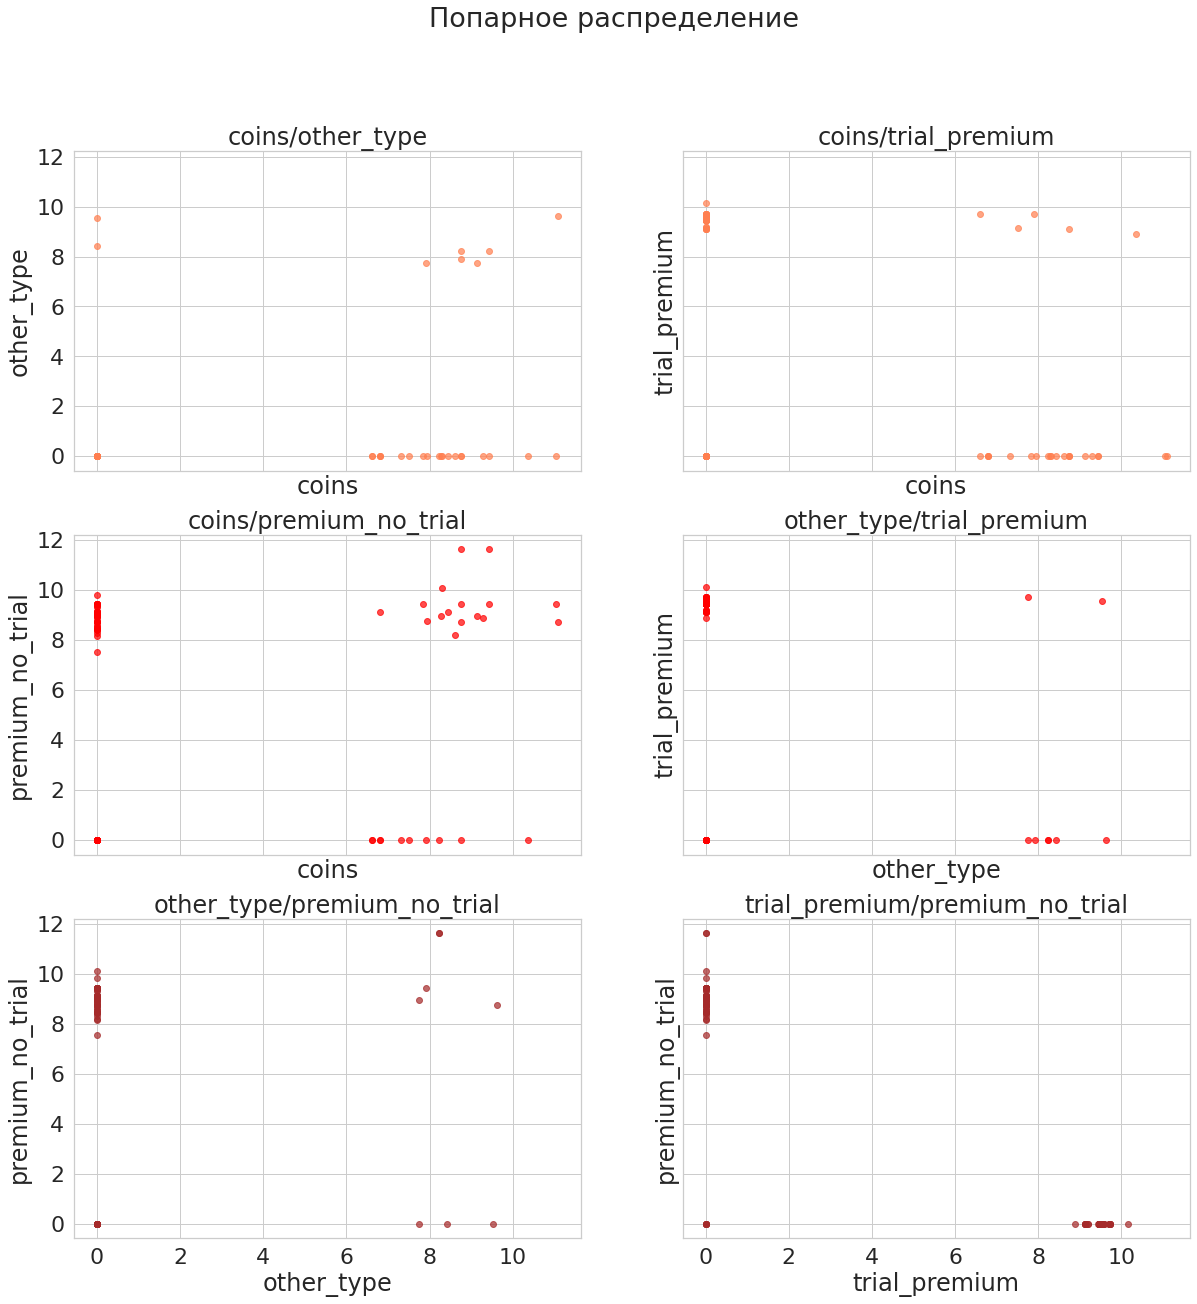

In [208]:
# Графики распределения значений

# import matplotlib.dates as mdates

#задаём значения для будущих осей
var1 = prod_types_tab.coins
var2 = prod_types_tab.other_type
var3 = prod_types_tab.trial_premium
var4 = prod_types_tab.premium_no_trial

#задаём сетку, совместное использование осей
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 20), sharey=True, sharex=True)

#заголовок
fig.suptitle('Попарное распределение', fontsize=27)

# подзаголовки графиков
axs[0, 0].set_title("coins/other_type")
axs[0, 1].set_title("coins/trial_premium")
axs[1, 0].set_title("coins/premium_no_trial")
axs[1, 1].set_title("other_type/trial_premium")
axs[2, 0].set_title("other_type/premium_no_trial")
axs[2, 1].set_title("trial_premium/premium_no_trial")

# подписи осей
axs[0, 0].set_xlabel("coins")
axs[0, 1].set_xlabel("coins")
axs[1, 0].set_xlabel("coins")
axs[1, 1].set_xlabel("other_type")
axs[2, 0].set_xlabel("other_type")
axs[2, 1].set_xlabel("trial_premium")

axs[0, 0].set_ylabel("other_type")
axs[0, 1].set_ylabel("trial_premium")
axs[1, 0].set_ylabel("premium_no_trial")
axs[1, 1].set_ylabel("trial_premium")
axs[2, 0].set_ylabel("premium_no_trial")
axs[2, 1].set_ylabel("premium_no_trial")

#добавляем данные на графики
axs[0, 0].scatter(var1, var2, alpha=0.7, color='coral')
axs[0, 1].scatter(var1, var3, alpha=0.7, color='coral')
axs[1, 0].scatter(var1, var4, alpha=0.7, color='red')
axs[1, 1].scatter(var2, var3, alpha=0.7, color='red')
axs[2, 0].scatter(var2, var4, alpha=0.7, color='brown')
axs[2, 1].scatter(var3, var4, alpha=0.7, color='brown')

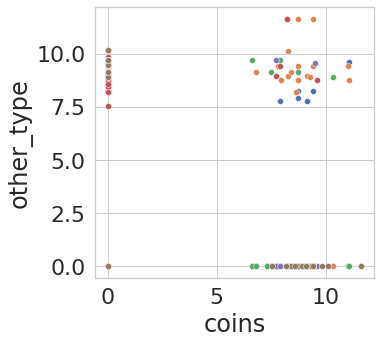

In [209]:
sns.scatterplot(data=prod_types_tab, x="coins", y="other_type")
sns.scatterplot(data=prod_types_tab, x="coins", y="premium_no_trial")
sns.scatterplot(data=prod_types_tab, x="coins", y="trial_premium")
sns.scatterplot(data=prod_types_tab, x="other_type", y="premium_no_trial")
sns.scatterplot(data=prod_types_tab, x="other_type", y="trial_premium")
sns.scatterplot(data=prod_types_tab, x="premium_no_trial", y="trial_premium")

In [210]:
# матрица корреляций
prod_types_tab.corr()

product_type,coins,other_type,premium_no_trial,trial_premium,premium_all
product_type,,,,,
coins,1.000000,0.361011,0.178125,-0.278938,-0.216847
other_type,0.361011,1.000000,0.097150,-0.094754,0.000171
premium_no_trial,0.178125,0.097150,1.000000,-0.880076,0.198392
trial_premium,-0.278938,-0.094754,-0.880076,1.000000,0.290795
premium_all,-0.216847,0.000171,0.198392,0.290795,1.000000


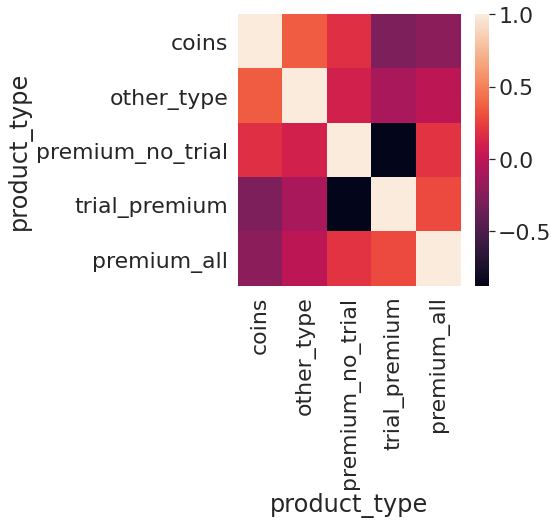

In [211]:
sns.heatmap(prod_types_tab.corr())

## Статистическая оценка эксперимента

Так как не обнаружено корреляции между coins, others и продуктами premium, для расчёта метрик и оценки эффекта от премимум можно использовать доходы от продуктов премиум.

На этапе анализа данных из датасетов были исключены дубликаты и пропущенные значения, а также отфильтрованы страны и строки где дата регистрации позднее даты оплаты.

<br><b>В блоке статисического анализа:</b>
<br><b>1)</b>Оценим датасеты и подготовим выборки с расчитанной метрикой
<br><b>2)</b>Проведём оценку распределений и выберем статистический критерий
<br><b>3)</b>Выполним тест

<br><b>1)</b>Оценим как изменился размер датасетов.

In [212]:
print(f'size')
print(f'user_test  {user_test.shape}')
print(f'user_control1  {user_control1.shape}')
print(f'user_control2  {user_control2.shape}')
print(f'transactions_test  {transactions_test.shape}')
print(f'transactions_control1  {transactions_control1.shape}')
print(f'transactions_control2  {transactions_control2.shape}')

size
user_test  (4044, 13)
user_control1  (4096, 13)
user_control2  (4001, 13)
transactions_test  (156, 9)
transactions_control1  (222, 9)
transactions_control2  (195, 9)


Сплитование пользователей количественно корректно, таблицы user примерно одинаковы.
<br>Таблицы по транзакциям количественно отличаются, тестовая выборка меньше контрольных.
<br>Посчитаем ARPU, оценим количество наблюдений ещё раз.
<br>\${ARPU} = {Доходы} / {ВсегоПользователей}\$

In [213]:
# для test
# агрегируем доход по пользователям в датасете с транзакциями
rpu_test = transactions_test \
    .query('product_type == "trial_premium" or product_type == "premium_no_trial"') \
    .groupby('uid', as_index=False) \
    .agg({'revenue': 'sum', 'payment_id': 'min'}) \
    .rename(columns={'payment_id': 'count_cust'})
# объединяем датасеты транзакций и пользователей, считаем количество пользователей, количество платящих пользователей и сумму дохода
arpu_test = user_test \
    .merge(rpu_test, how='left', on='uid') \
    .groupby('country', as_index=False) \
    .agg({'revenue': 'sum', 'count_cust': 'count', 'uid': 'count'})
# считаем arpu, arppu, cr по стране
arpu_test = arpu_test \
    .assign(arpu = arpu_test.revenue / arpu_test.uid, cr = arpu_test.count_cust / arpu_test.uid * 100, arppu = arpu_test.revenue / arpu_test.count_cust)


# для control1
rpu_test = transactions_control1 \
    .query('product_type == "trial_premium" or product_type == "premium_no_trial"') \
    .groupby('uid', as_index=False) \
    .agg({'revenue': 'sum', 'payment_id': 'min'}) \
    .rename(columns={'payment_id': 'count_cust'})

arpu_control1 = user_control1 \
    .merge(rpu_test, how='left', on='uid') \
    .groupby('country', as_index=False) \
    .agg({'revenue': 'sum', 'count_cust': 'count', 'uid': 'count'})

arpu_control1 = arpu_control1 \
    .assign(arpu = arpu_control1.revenue / arpu_control1.uid, cr = arpu_control1.count_cust / arpu_control1.uid * 100, arppu = arpu_control1.revenue / arpu_control1.count_cust) \
    .fillna(0)


# для control2
rpu_test = transactions_control2 \
    .query('product_type == "trial_premium" or product_type == "premium_no_trial"') \
    .groupby('uid', as_index=False) \
    .agg({'revenue': 'sum', 'payment_id': 'min'}) \
    .rename(columns={'payment_id': 'count_cust'})

arpu_control2 = user_control2 \
    .merge(rpu_test, how='left', on='uid') \
    .groupby('country', as_index=False) \
    .agg({'revenue': 'sum', 'count_cust': 'count', 'uid': 'count'})

arpu_control2 = arpu_control2 \
    .assign(arpu = arpu_control2.revenue / arpu_control2.uid, cr = arpu_control2.count_cust / arpu_control2.uid * 100, arppu = arpu_control2.revenue / arpu_control2.count_cust) \
    .fillna(0)
arpu_test

,country,revenue,count_cust,uid,arpu,cr,arppu
0,Argentina,63180.0,6,395,159.949367,1.518987,10530.000000
1,Belgium,12831.0,1,89,144.168539,1.123596,12831.000000
2,Canada,39884.0,4,135,295.437037,2.962963,9971.000000
3,Chile,32799.0,2,270,121.477778,0.740741,16399.500000
4,France,91585.0,7,353,259.447592,1.983003,13083.571429
5,Germany,62972.0,6,208,302.750000,2.884615,10495.333333
6,Israel,68302.0,5,106,644.358491,4.716981,13660.400000
7,Italy,43082.0,5,319,135.053292,1.567398,8616.400000
8,Latvia,6357.0,1,2,3178.500000,50.000000,6357.000000
9,Mexico,6214.0,1,7,887.714286,14.285714,6214.000000


In [214]:
print(f'size')
print(f'arpu_test  {arpu_test.shape}')
print(f'arpu_control1  {arpu_control1.shape}')
print(f'arpu_control2  {arpu_control2.shape}')

size
arpu_test  (16, 7)
arpu_control1  (15, 7)
arpu_control2  (15, 7)


Выборки количественно совпадают.

<br>Посмотрим на гистограммы метрик по странам.

In [215]:
# готовим объединённую таблицу по всем метрикам
metrics_merge = arpu_test \
    .merge(arpu_control1, how='outer', on='country') \
    .merge(arpu_control2, how='outer', on='country') \
    .drop(columns=['count_cust_x', 'revenue_x', 'uid_x', 'count_cust_y', 'revenue_y', 'uid_y', 'count_cust', 'revenue', 'uid']) \
    .fillna(0) \
    .rename(columns={'arpu_x': 'arpu_t', 'arpu_y': 'arpu_c1', 'arpu': 'arpu_c2', 'arppu_x': 'arppu_t', 'arppu_y': 'arppu_c1', 'arppu': 'arppu_c2', 'cr_x': 'cr_t', 'cr_y': 'cr_c1', 'cr': 'cr_c2'})
metrics_merge

,country,arpu_t,cr_t,arppu_t,arpu_c1,cr_c1,arppu_c1,arpu_c2,cr_c2,arppu_c2
0,Argentina,159.949367,1.518987,10530.000000,179.568831,2.077922,8641.750000,153.898990,2.020202,7618.000000
1,Belgium,144.168539,1.123596,12831.000000,398.018692,2.803738,14196.000000,898.920455,9.090909,9888.125000
2,Canada,295.437037,2.962963,9971.000000,352.190840,4.580153,7689.500000,101.242424,1.515152,6682.000000
3,Chile,121.477778,0.740741,16399.500000,210.181818,2.447552,8587.428571,149.269504,1.773050,8418.800000
4,France,259.447592,1.983003,13083.571429,306.857143,3.846154,7978.285714,214.324324,2.702703,7930.000000
5,Germany,302.750000,2.884615,10495.333333,108.101604,2.139037,5053.750000,134.745000,1.500000,8983.000000
6,Israel,644.358491,4.716981,13660.400000,770.401869,10.280374,7493.909091,170.054054,2.702703,6292.000000
7,Italy,135.053292,1.567398,8616.400000,347.750000,3.012048,11545.300000,149.385965,1.754386,8515.000000
8,Latvia,3178.500000,50.000000,6357.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Mexico,887.714286,14.285714,6214.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


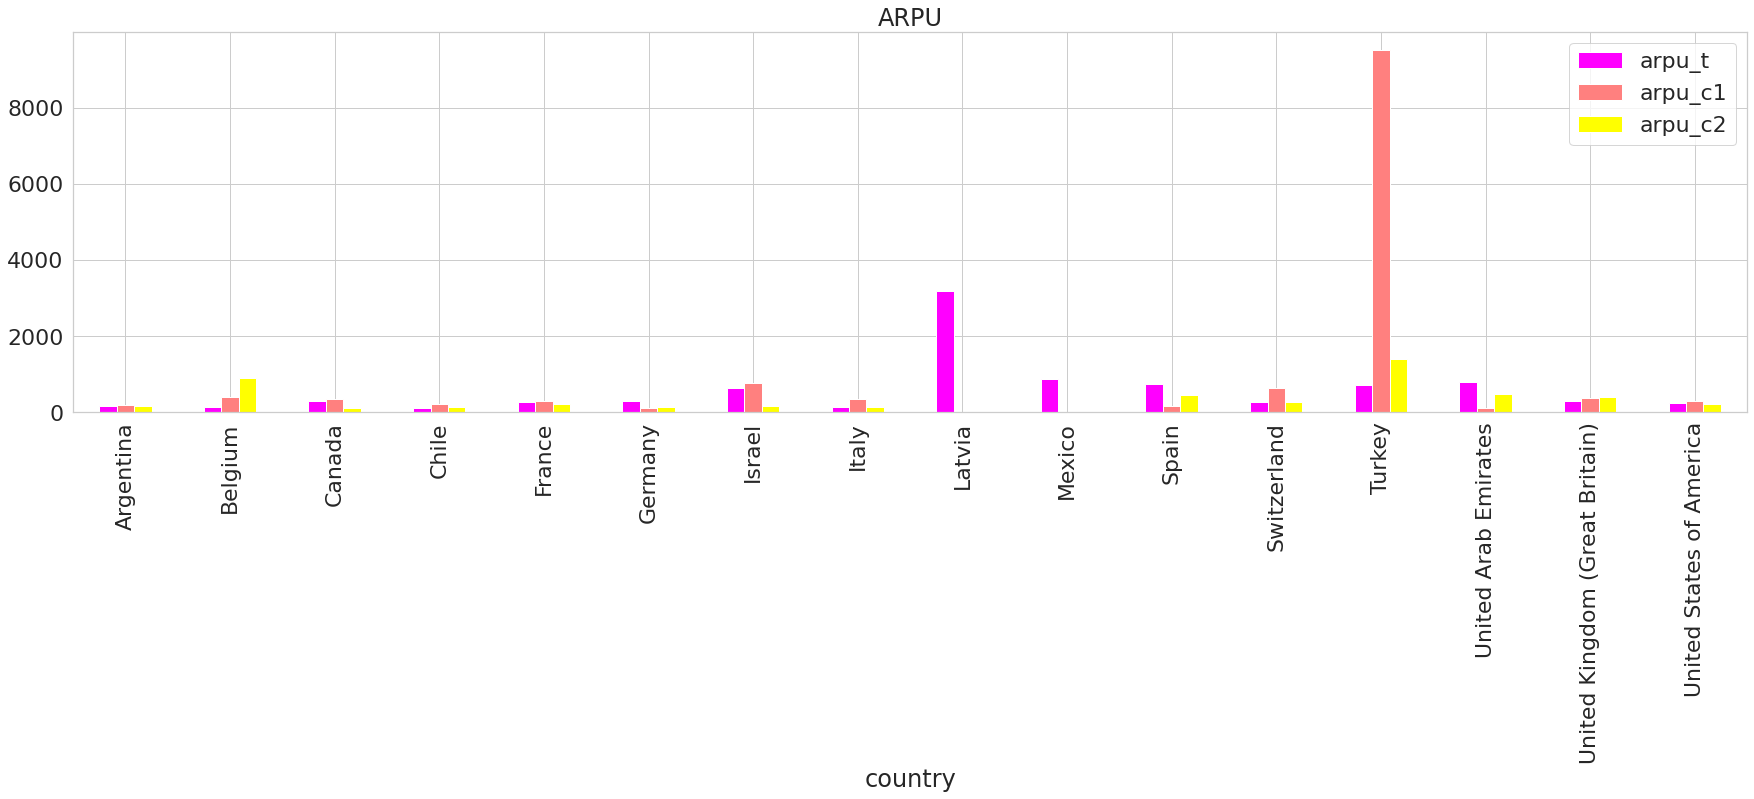

In [216]:
sns.set(
font_scale=2,
style="whitegrid",
rc={'figure.figsize':(30,7)}
        )
metrics_merge[['country', 'arpu_t', 'arpu_c1', 'arpu_c2']].set_index('country').plot.bar(colormap='spring', title='ARPU')

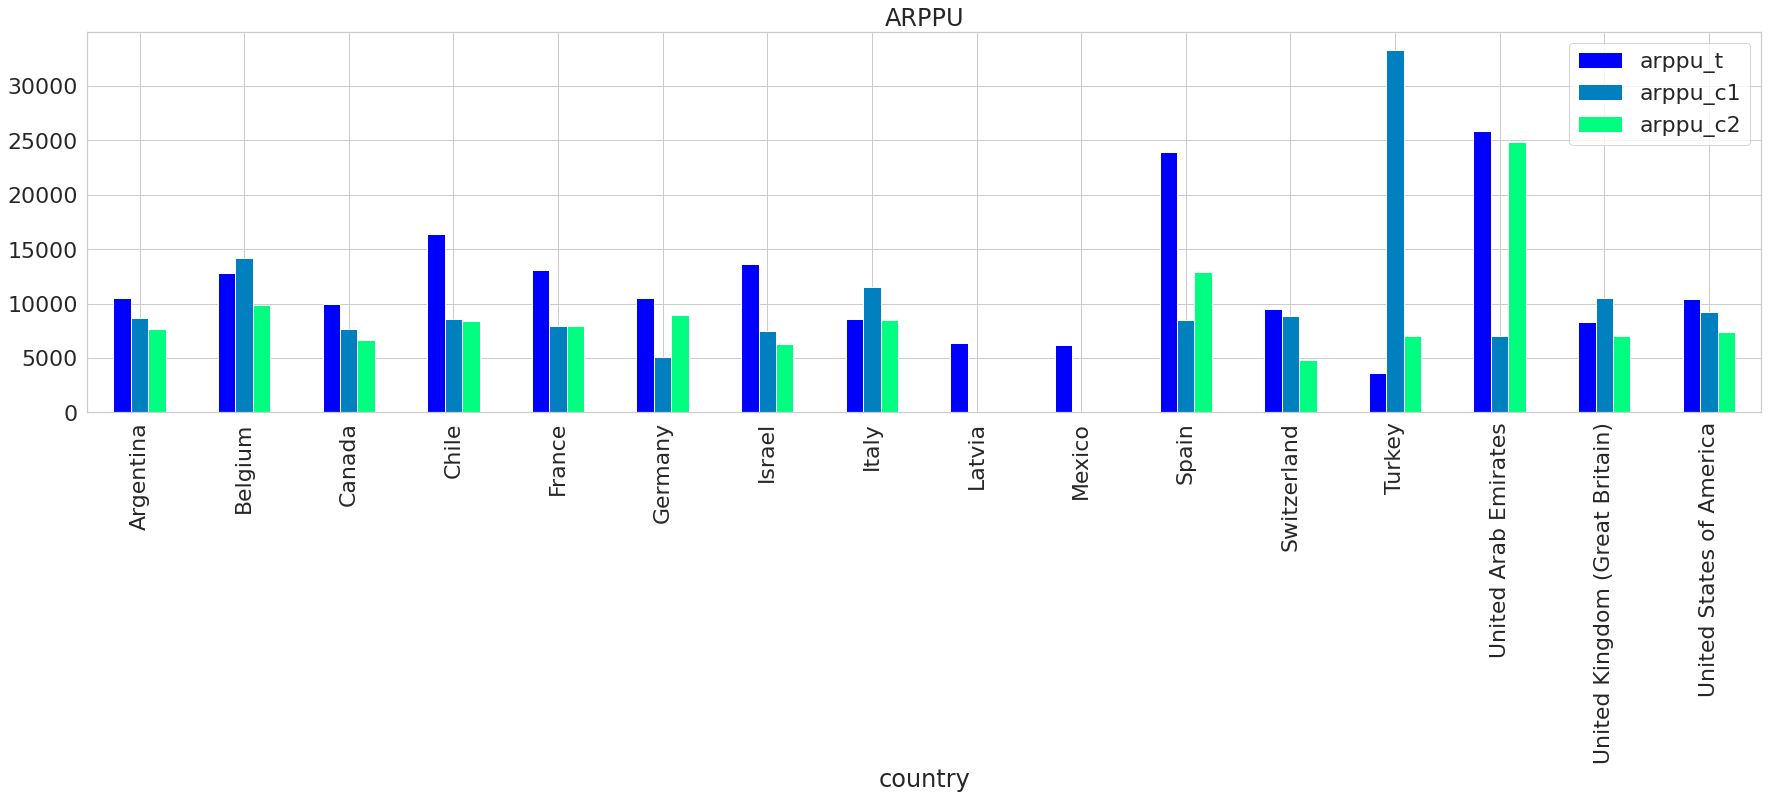

In [217]:
metrics_merge[['country', 'arppu_t', 'arppu_c1', 'arppu_c2']].set_index('country').plot.bar(colormap='winter', title='ARPPU')

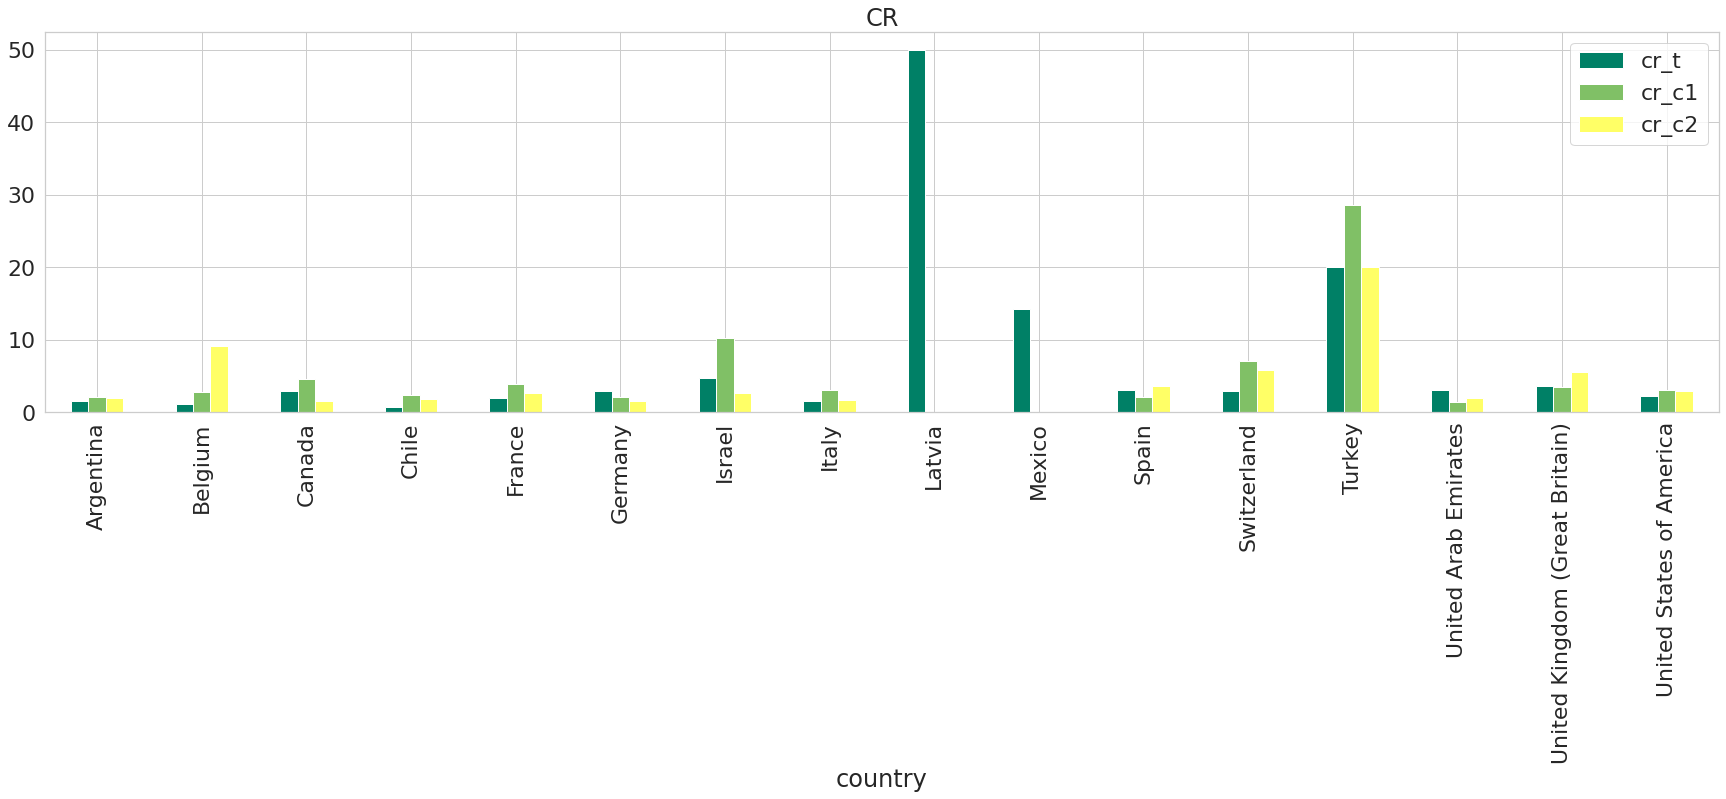

In [218]:
metrics_merge[['country', 'cr_t', 'cr_c1', 'cr_c2']].set_index('country').plot.bar(colormap='summer', title='CR')

По графику ARPU сложно проследить тенденцию, на графике ARPPU можно увидеть liftup по многим странам, по графику CR наоборот снижение в тестовой выборке. И видим новых активных покупателей подписки в Мексике и Латвии, которых не наблюдается в контрольных выборках.

<br><b>2)</b>Посмотрим на графики распределения.

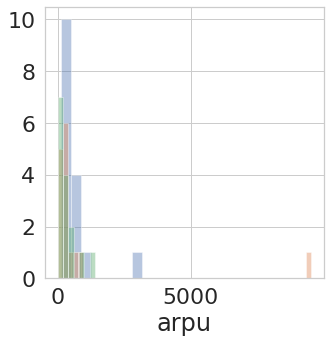

In [219]:
# графики распределения ARPU
sns.set(
font_scale=2,
style="whitegrid",
rc={'figure.figsize':(5,5)}
        )

sns.distplot(arpu_test.arpu, kde=False)
sns.distplot(arpu_control1.arpu, kde=False)
sns.distplot(arpu_control2.arpu, kde=False)

По графикам видно, что распределение не похоже на нормальное. Прогоним выборки через тест на нормальность.
<br><b><i>H0:</i></b> выборка принадлежит генеральной совокупности с нормальным распределением.

In [220]:
print(f'normal_tests')
print(f'arpu_test_norm  {st.normaltest(arpu_test.arpu)}')
print(f'arpu_control1_norm  {st.normaltest(arpu_control1.arpu)}')
print(f'arpu_control2_norm  {st.normaltest(arpu_control2.arpu)}')

normal_tests
arpu_test_norm  NormaltestResult(statistic=33.567898134880785, pvalue=5.138348254262982e-08)
arpu_control1_norm  NormaltestResult(statistic=40.20140590553857, pvalue=1.863698369398601e-09)
arpu_control2_norm  NormaltestResult(statistic=17.300227177984006, pvalue=0.00017510695680524437)


<br><b><i>H0:</i></b> что выборки принадлежат ГС с нормальным распределением не подтверждается, p-value < 0,05 для всех 3х выборок (test, control1, control2) для основной метрики ARPU.
<br>Попробуем нормализовать выборки через логарифмирование и ещё раз протестировать на нормальность распределения.

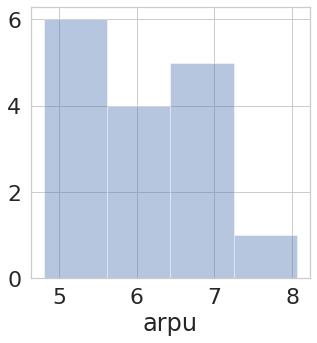

In [221]:
# график распределения логарифмированной тестовой выборки
sns.distplot(np.log(arpu_test.arpu).replace([np.inf, -np.inf], np.nan).fillna(0), kde=False)

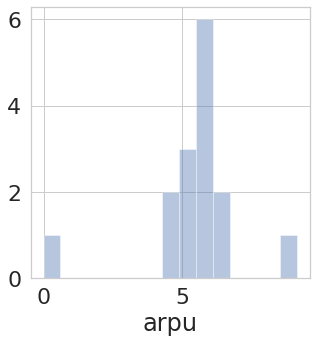

In [222]:
# график распределения логарифмированной выборки control1
sns.distplot(np.log(arpu_control1.arpu).replace([np.inf, -np.inf], np.nan).fillna(0), kde=False)

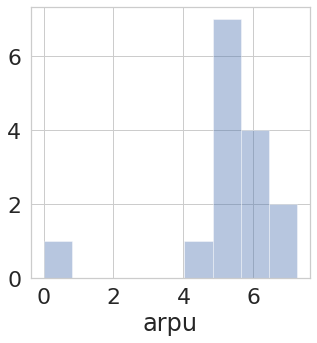

In [223]:
# график распределения логарифмированной выборки control2
sns.distplot(np.log(arpu_control2.arpu).replace([np.inf, -np.inf], np.nan).fillna(0), kde=False)

In [224]:
print(f'normal_tests')
print(f'arpu_test_norm  {st.normaltest(np.log(arpu_test.arpu).replace([np.inf, -np.inf], np.nan).fillna(0))}')
print(f'arpu_control1_norm  {st.normaltest(np.log(arpu_control1.arpu).replace([np.inf, -np.inf], np.nan).fillna(0))}')
print(f'arpu_control2_norm  {st.normaltest(np.log(arpu_control2.arpu).replace([np.inf, -np.inf], np.nan).fillna(0))}')

normal_tests
arpu_test_norm  NormaltestResult(statistic=3.0904452870079546, pvalue=0.21326438400702236)
arpu_control1_norm  NormaltestResult(statistic=14.851284428832217, pvalue=0.0005957781364888228)
arpu_control2_norm  NormaltestResult(statistic=24.573087564419147, pvalue=4.613407674261869e-06)


<br><b><i>H0</i></b> после логарифмирования выборок тоже не подтверждается.
<br>Так как выборки мы не можем назвать нормальными и размер их < 30, будем использовать непараметрический статистический критерий.

<br>Проверим нормальность распределений также вспомогательных метрик.

In [225]:
# normaltest для ARPPU
print(f'normal_tests_arppu')
print(f'arppu_test_norm  {st.normaltest(arpu_test.arppu)}')
print(f'arppu_control1_norm  {st.normaltest(arpu_control1.arppu)}')
print(f'arppu_control2_norm  {st.normaltest(arpu_control2.arppu)}')
print(f'arppu_test_norm  {st.normaltest(np.log(arpu_test.arppu).replace([np.inf, -np.inf], np.nan).fillna(0))}')
print(f'arppu_control1_norm  {st.normaltest(np.log(arpu_control1.arppu).replace([np.inf, -np.inf], np.nan).fillna(0))}')
print(f'arppu_control2_norm  {st.normaltest(np.log(arpu_control2.arppu).replace([np.inf, -np.inf], np.nan).fillna(0))}')

normal_tests_arppu
arppu_test_norm  NormaltestResult(statistic=6.724947328256507, pvalue=0.03464944176589953)
arppu_control1_norm  NormaltestResult(statistic=26.451918119720983, pvalue=1.8031795045853738e-06)
arppu_control2_norm  NormaltestResult(statistic=19.986273864878882, pvalue=4.571258420475773e-05)
arppu_test_norm  NormaltestResult(statistic=0.8326404664154422, pvalue=0.6594690527765688)
arppu_control1_norm  NormaltestResult(statistic=38.39437225549563, pvalue=4.600107667496327e-09)
arppu_control2_norm  NormaltestResult(statistic=38.82761639766485, pvalue=3.7041641698446004e-09)


In [226]:
# normaltest для CR
print(f'normal_tests_cr')
print(f'cr_test_norm  {st.normaltest(arpu_test.cr)}')
print(f'cr_control1_norm  {st.normaltest(arpu_control1.cr)}')
print(f'cr_control2_norm  {st.normaltest(arpu_control2.cr)}')
print(f'cr_test_norm  {st.normaltest(np.log(arpu_test.cr).replace([np.inf, -np.inf], np.nan).fillna(0))}')
print(f'cr_control1_norm  {st.normaltest(np.log(arpu_control1.cr).replace([np.inf, -np.inf], np.nan).fillna(0))}')
print(f'cr_control2_norm  {st.normaltest(np.log(arpu_control2.cr).replace([np.inf, -np.inf], np.nan).fillna(0))}')

normal_tests_cr
cr_test_norm  NormaltestResult(statistic=31.124963533020228, pvalue=1.7430106635503108e-07)
cr_control1_norm  NormaltestResult(statistic=31.739795149297017, pvalue=1.2817137841887654e-07)
cr_control2_norm  NormaltestResult(statistic=25.91494276961945, pvalue=2.3585314847992233e-06)
cr_test_norm  NormaltestResult(statistic=5.817032530306791, pvalue=0.054556617400876445)
cr_control1_norm  NormaltestResult(statistic=7.120897306534728, pvalue=0.028426068404350528)
cr_control2_norm  NormaltestResult(statistic=4.501862137253319, pvalue=0.1053011363211283)


Получаем значимый p-value только для CR в тестовой выборке, для остальных распределений <b><i>H0</i></b> что выборки принадлежат ГС с нормальным распределением не подтверждается, p-value < 0,05. Но так как для параметрических тестов необходима нормальность распределения для обоих выборок, будем использовать непараметрические тесты как и для основной метрики ARPU.

<br><b>3)</b>применяем критерий Манна-Уитни
<br><b><i>H0:</i></b> – вероятность случайно взять из тестовой выборки более высокое значение ARPU, чем из контрольной = 50%
<br>*если вероятность не = 50%, то в какой-то из выборок более высокие значения встречаются чаще

In [227]:
# для ARPU
from scipy.stats import mannwhitneyu
print(f'Mann–Whitney_U_test')
print(f'arpu_test-contr1_Mann–Whitney  {mannwhitneyu(arpu_test.arpu, arpu_control1.arpu)}')
print(f'arpu_test-contr2_Mann–Whitney  {mannwhitneyu(arpu_test.arpu, arpu_control2.arpu)}')
print(f'arpul_test_-contr1_Mann–Whitney  {mannwhitneyu(np.log(arpu_test.arpu).replace([np.inf, -np.inf], np.nan).fillna(0), np.log(arpu_control1.arpu).replace([np.inf, -np.inf], np.nan).fillna(0))}')
print(f'arpul_test_-contr2_Mann–Whitney  {mannwhitneyu(np.log(arpu_test.arpu).replace([np.inf, -np.inf], np.nan).fillna(0), np.log(arpu_control2.arpu).replace([np.inf, -np.inf], np.nan).fillna(0))}')

Mann–Whitney_U_test
arpu_test-contr1_Mann–Whitney  MannwhitneyuResult(statistic=132.0, pvalue=0.6494132869819362)
arpu_test-contr2_Mann–Whitney  MannwhitneyuResult(statistic=151.0, pvalue=0.22796467743471693)
arpul_test_-contr1_Mann–Whitney  MannwhitneyuResult(statistic=132.0, pvalue=0.6494132869819362)
arpul_test_-contr2_Mann–Whitney  MannwhitneyuResult(statistic=151.0, pvalue=0.22796467743471693)


In [228]:
# st.ks_2samp(data1=arpu_test.arpu, data2=arpu_control1.arpu)

<br><b><i>H0</i></b> не отвергается, т.к. p-value > 0,05, в выборка тест-контроль1 или тест-контроль2 вероятность взять более высокие значения 50/50%.

Иными словами нам не удалось задетектировать uplift или падение ключевой метрики APRU и найти статистически значимый эффект.

Оценим вспомогательные метрики.

In [229]:
# для ARPPU
print(f'Mann–Whitney_U_test')
print(f'arppu_test-contr1_Mann–Whitney  {mannwhitneyu(arpu_test.arppu, arpu_control1.arppu)}')
print(f'arppu_test-contr2_Mann–Whitney  {mannwhitneyu(arpu_test.arppu, arpu_control2.arppu)}')
print(f'arppul_test_-contr1_Mann–Whitney  {mannwhitneyu(np.log(arpu_test.arppu).replace([np.inf, -np.inf], np.nan).fillna(0), np.log(arpu_control1.arppu).replace([np.inf, -np.inf], np.nan).fillna(0))}')
print(f'arppul_test_-contr2_Mann–Whitney  {mannwhitneyu(np.log(arpu_test.arppu).replace([np.inf, -np.inf], np.nan).fillna(0), np.log(arpu_control2.arppu).replace([np.inf, -np.inf], np.nan).fillna(0))}')

Mann–Whitney_U_test
arppu_test-contr1_Mann–Whitney  MannwhitneyuResult(statistic=156.0, pvalue=0.1605391093203392)
arppu_test-contr2_Mann–Whitney  MannwhitneyuResult(statistic=174.0, pvalue=0.034449283334633644)
arppul_test_-contr1_Mann–Whitney  MannwhitneyuResult(statistic=156.0, pvalue=0.1605391093203392)
arppul_test_-contr2_Mann–Whitney  MannwhitneyuResult(statistic=174.0, pvalue=0.034449283334633644)


In [230]:
# для CR
print(f'Mann–Whitney_U_test')
print(f'cr_test-contr1_Mann–Whitney  {mannwhitneyu(arpu_test.cr, arpu_control1.cr)}')
print(f'cr_test-contr2_Mann–Whitney  {mannwhitneyu(arpu_test.cr, arpu_control2.cr)}')
print(f'crl_test_-contr1_Mann–Whitney  {mannwhitneyu(np.log(arpu_test.cr).replace([np.inf, -np.inf], np.nan).fillna(0), np.log(arpu_control1.cr).replace([np.inf, -np.inf], np.nan).fillna(0))}')
print(f'crl_test_-contr2_Mann–Whitney  {mannwhitneyu(np.log(arpu_test.cr).replace([np.inf, -np.inf], np.nan).fillna(0), np.log(arpu_control2.cr).replace([np.inf, -np.inf], np.nan).fillna(0))}')

Mann–Whitney_U_test
cr_test-contr1_Mann–Whitney  MannwhitneyuResult(statistic=116.0, pvalue=0.8899640895977055)
cr_test-contr2_Mann–Whitney  MannwhitneyuResult(statistic=133.5, pvalue=0.6072703407164293)
crl_test_-contr1_Mann–Whitney  MannwhitneyuResult(statistic=115.0, pvalue=0.8588186957821996)
crl_test_-contr2_Mann–Whitney  MannwhitneyuResult(statistic=132.5, pvalue=0.6351880914980912)


Для ARPPU частично получены высокие значения p-value, для выборок test и control1 <br><b><i>H0</i></b> отклоняем, можем статистически значимо сказать, что вероятность взять более высокие значения CR в test или control1 больше, чем 50%.

<br>Для CR <br><b><i>H0</i></b> отклоняем для всех срезов.

<br>Обратимся к гистограммам вспомогательных метрик. На графиках заметно, что в некоторых странах наблюдается uplift CR и в то же время спад ARPPU и наоборот, что в целом даёт незначительные изменения ARPU. Поэтому в рекомендациях обратим внимание на применимость новых систем оплат для стран с ростом ARPU Латвия, Мексика, Испания, ОАЭ.

### Рекомендации к источникам:
- Выяснить причину дублирования транзакций в датасетах
- Выяснить причину наличия логов даты покупки раньше даты регистрации
- Обратить внимание на несоответствие стран в датасетах пользователей

### Выводы по результатам АБ-теста:
<br>Эксперимент на основе ключевой метрики ARPU показал, что в тестовой и контрольных выборках более высокие значения ARPU встречаются одинаково часто, что не даёт основания говорить об отличии тестового и контрольных датасетов.

<br>Тогда как мы получили статзначимые результаты для вспомогательных метрик ARPPU и CR.
<br>И на основе оценки гистограмм можем рекомендовать раскатывать новые механики оплат премиум-подписки в странах с ростом ARPU на тестовом датасете: в Латвии, Мексике, Испании, ОАЭ.